In [1]:
from collections import Counter
import os

from graphviz import Source
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import networkx as nx
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns


sns.set_style('white')
sns.set_context('notebook')

def plot_style(figsize=(12, 6), labelsize=20, titlesize=24, ticklabelsize=14, **kwargs):
   basic_style = {
       'figure.figsize': figsize,
       'axes.labelsize': labelsize,
       'axes.titlesize': titlesize,
       'xtick.labelsize': ticklabelsize,
       'ytick.labelsize': ticklabelsize,
       'axes.spines.top': False,
       'axes.spines.right': False,
       'axes.spines.left': False,
       'axes.grid': False,
       'axes.grid.axis': 'y',
   }
   basic_style.update(kwargs)
   return plt.rc_context(rc=basic_style)

blue = sns.xkcd_rgb['ocean blue']

In [2]:
def new_count_row(all_clone_names, clone_name=None):
    """ Create a DataFrame row with one entry per clone name. 
    
    If `clone_name` is not None, initialize that entry to 1.
    """
    row = pd.Series(data=0, index=all_clone_names)
    if clone_name is not None:
        row[clone_name] = 1
    return row

def dfs_clones_count(g, clones, all_clone_names, source_node):
    clones_count = pd.DataFrame({sample_name: new_count_row(all_clones, clone_name) for sample_name, clone_name in clones.items()})
    for pre_node, post_node, edge_label in nx.dfs_labeled_edges(g, source_node):
        if edge_label is not 'reverse' or pre_node == post_node: 
            continue
        pre_node_counter = clones_count.get(pre_node, new_count_row(all_clones))
        if post_node not in clones_count.columns:
            print('!! possible mutation in a leaf: not found', post_node)
            continue
        clones_count[pre_node] = pre_node_counter + clones_count[post_node]

    return clones_count

def purity(clones_count):
    return clones_count.div(clones_count.sum(axis=0), axis=1)

def get_root_node(t):
    root_nodes = [n for n,d in t.in_degree() if d==0]
    assert len(root_nodes) == 1
    root_node = root_nodes[0]
    return root_node

# Load clones data

In [3]:
# read clones data
clones_data = pd.read_csv('../../data/YFV2001_clone_key/sample_order_clone_key_mem_scores_scRNAseq_sub1.csv')

In [4]:
clones_data

,clone,tree_id,cell_id,mem_score,timepoint
0,bulk,s0,P3861_210.txt,NaN,NaN
1,107.0,s10,P1299_1141,0.043586,15.0
2,107.0,s54,P1299_1514,NaN,136.0
3,107.0,s55,P1299_1529,NaN,136.0
4,107.0,s56,P1299_1535,NaN,136.0
...,...,...,...,...,...
68,149.0,s26,P3128_1042,0.771754,593.0
69,149.0,s31,P3128_1077,0.875278,593.0
70,149.0,s32,P3128_1086,0.926791,593.0
71,149.0,s41,P3128_1139,0.888676,593.0


In [5]:
# read gene expression
gene_expression = pd.read_csv('../../data/YFV2001_gene_expression/results/YFV2001_230127_normalized_gene_counts.csv')

In [6]:
# check if normalized to depth 10 000
gene_expression2 = gene_expression.copy()
gene_expression2 = gene_expression2.set_index('unique_name').T.reset_index()
gene_expression2 = gene_expression2[gene_expression2['index'].str.contains("P1299_1202")] 
#gene_expression2 = gene_expression2[gene_expression2['index'].str.contains("P1299_1200")]
gene_expression2 = gene_expression2.drop(['index'], axis=1)
gene_expression2 = gene_expression2.astype(float)
print(gene_expression2.sum().sum())
#gene_expression2

9999.999771498


In [7]:
# check max value
gene_expression2 = gene_expression.copy()
gene_expression2 = gene_expression2.set_index('unique_name').T.reset_index()
gene_expression2 = gene_expression2.drop(['index'], axis=1)
gene_expression2 = gene_expression2.astype(float)
gene_expression2.max().max()


1462.6903

In [8]:
# Fix df before merging
gene_expression = gene_expression.set_index('unique_name').T.reset_index()
gene_expression.rename(columns={'index': "cell_id"}, inplace=True)
#gene_expression

In [9]:
# check which samples overlap between clones map and gene expression mx
samples_in_both = set(clones_data['cell_id']).intersection(set(gene_expression['cell_id']))
len(samples_in_both)

71

In [10]:
# Merge clones data and gene expression
clones_gene_expression = pd.merge(clones_data, gene_expression, on='cell_id', how='inner')

In [11]:
clones_map = dict(clones_data[['tree_id', 'clone']].values)
all_clones = list(clones_data.clone.unique())

In [12]:
print(all_clones)

['bulk', '107.0', '108.0', '118.0', '122.0', '143.0', '149.0']


In [13]:

print('mem genes')
print(clones_gene_expression[['LTB', 'GZMK', 'CCR7', 'TCF7', 'IL7R', 'SELL', 'NELL2', 'LEF1', 'GPR183', 'CXCR3']].max())

print('eff genes')
print(clones_gene_expression[['GZMA', 'KLRD1', 'CCL4', 'CX3CR1', 'PRF1', 'CST7', 'S1PR5', 'ZEB2', 'GNLY', 'NKG7', 'GZMB', 'FGFBP2', 'GZMH']].max())


mem genes
LTB       50.572945
GZMK      27.028809
CCR7      26.589056
TCF7      21.293655
IL7R      33.005863
SELL      66.486040
NELL2     24.262810
LEF1      10.957982
GPR183    41.330700
CXCR3     11.357834
dtype: float64
eff genes
GZMA      140.456530
KLRD1      76.189310
CCL4       45.358196
CX3CR1     16.260984
PRF1       28.772488
CST7       73.894740
S1PR5       6.217905
ZEB2       11.441493
GNLY      219.292250
NKG7       72.570060
GZMB       61.795800
FGFBP2     27.657490
GZMH       43.157715
dtype: float64


In [34]:

print('mem genes')
print(clones_gene_expression[['CD8A', 'CD8B', 'IL7R', 'CCR7']].max())

print('eff genes')
print(clones_gene_expression[['GZMB', 'CX3CR1', 'PRF1', 'IFNG']].max())


mem genes
CD8A    39.939350
CD8B    26.104591
IL7R    33.005863
CCR7    26.589056
dtype: float64
eff genes
GZMB      61.795800
CX3CR1    16.260984
PRF1      28.772488
IFNG      10.248795
dtype: float64


# Load tree

In [64]:
#error_rate = 0.06
#tree_number = 0

#tree_filename = f'../../../mt-SCITE/mt-SCITE_output/YFV2001/0.07_10_map0.gv'
tree_filename = f'../../../mt-SCITE/mt-SCITE_output/YFV2001/0.06_1_map0.gv'

#{error_rate}/{error_rate}_map{tree_number}.gv'
tree = nx.drawing.nx_pydot.read_dot(tree_filename)

In [65]:
tree = nx.drawing.nx_pydot.read_dot(tree_filename)

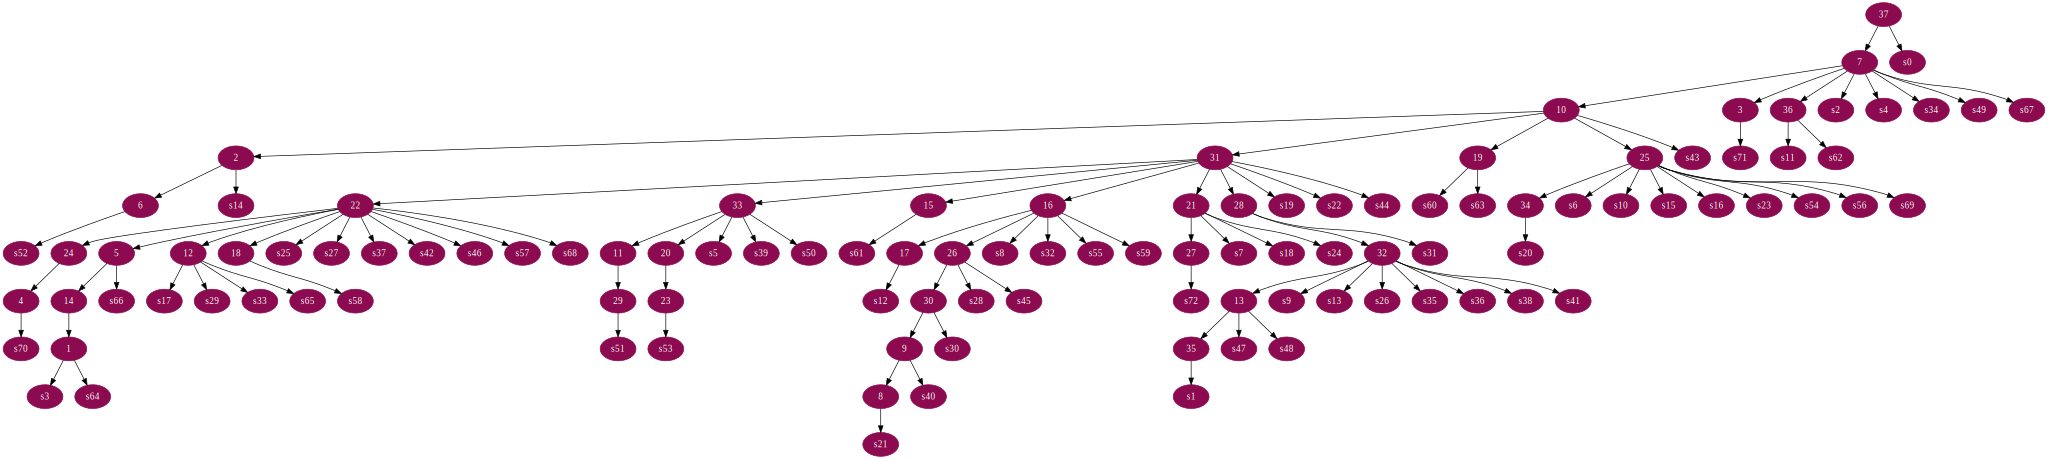

In [37]:
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph

g = to_agraph(tree)
g.layout(prog='dot')
#g.draw(f'../../data/YFV2001_figures/0.0556_map0_GPR183_viridis.svg')
Source(g)

In [38]:
# The file contains a node which is not attached to the tree. Check that it is removed.
print(len(tree.nodes()))
#tree.remove_node('\\n')
print(len(tree.nodes()))

110
110


# Color by normalized gene expression

In [46]:
clones_gene_expression.loc[clones_gene_expression['tree_id'] == 's11', "IFNG"]

51    7.768285
Name: IFNG, dtype: float64

In [154]:
# Make a dict with tree id and gene expression

cell_id_to_expression = pd.Series(clones_gene_expression.IFNG.values,index=clones_gene_expression.tree_id).to_dict()
#cell_id_to_expression

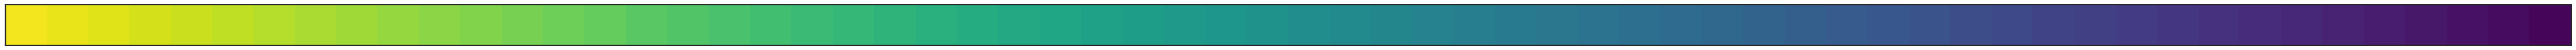

In [161]:
expression_colors = sns.color_palette("viridis", 62)[::-1]
sns.palplot(expression_colors)
plt.savefig('../../data/YFV2001_figures/mem_color_key.svg', dpi=300, bbox_inches='tight', transparent=True)

In [156]:
expression_colors = np.array(expression_colors) * 255


In [157]:
def rgb_to_hex(colortuple):
    return '#' + ''.join(f'{int(i):02X}' for i in colortuple)


clones_count = dfs_clones_count(tree, clones_map, all_clones, source_node=get_root_node(tree))
clones_purity = purity(clones_count)

for n in tree.nodes:
    node_dict = tree.nodes[n]
    if n.startswith('s'):
        # This is the style for sample nodes
        node_dict['shape'] = 'circle'
        #if n not in cell_id_to_mem_score:
        if n not in cell_id_to_expression:
            print(n + ' is not in expression mx')
            node_dict['fillcolor'] = 'white'
            node_dict['color'] = 'lightgrey'
            node_dict['fontcolor'] = 'white'
        else:
            #score = cell_id_to_mem_score[n]
            score = cell_id_to_expression[n]
            if np.isnan(score):
                node_dict['fillcolor'] = 'white'
                node_dict['color'] = 'black'
                #node_dict['penwidth'] = 3
            elif score == 0.0:
                node_dict['fillcolor'] = 'white'
                node_dict['color'] = 'black'
                node_dict['fontcolor'] = 'white'
            else:
                #print(n, score, mem_score_colors[int(score*100)])
                #node_dict['fillcolor'] = rgb_to_hex(mem_score_colors[int(score*100)])
                #node_dict['fillcolor'] = rgb_to_hex(mem_score_colors[int(score*1)])
                node_dict['fillcolor'] = rgb_to_hex(expression_colors[int(score*1)])
                node_dict['fontcolor'] = rgb_to_hex(expression_colors[int(score*1)])
    else:
        if n in clones_purity:
            # This is the style for mutation nodes
            # Color is a mix of purities
            #node_dict['fillcolor'] = rgb_to_hex(mix_clones_colors(n, clones_purity))
            node_dict['fillcolor'] = '#EEF0F0'
            node_dict['fontcolor'] = '#EEF0F0'
        else:
            # Dangling mutation node
            node_dict['fillcolor'] = 'black'

s4 is not in expression mx
s0 is not in expression mx


In [158]:
#clones_purity

In [159]:
# Global graph style
tree.graph['node']['shape'] = 'square'
tree.graph['node']['fontcolor'] = 'black'
tree.graph['node']['color'] = 'black'
tree.graph['node']['style'] = 'filled,solid'
tree.graph['edges'] = {'arrowsize': '4.0'}
tree.graph

{'name': 'G',
 'node': {'color': 'black',
  'style': 'filled,solid',
  'fontcolor': 'black',
  'shape': 'square'},
 'edges': {'arrowsize': '4.0'}}

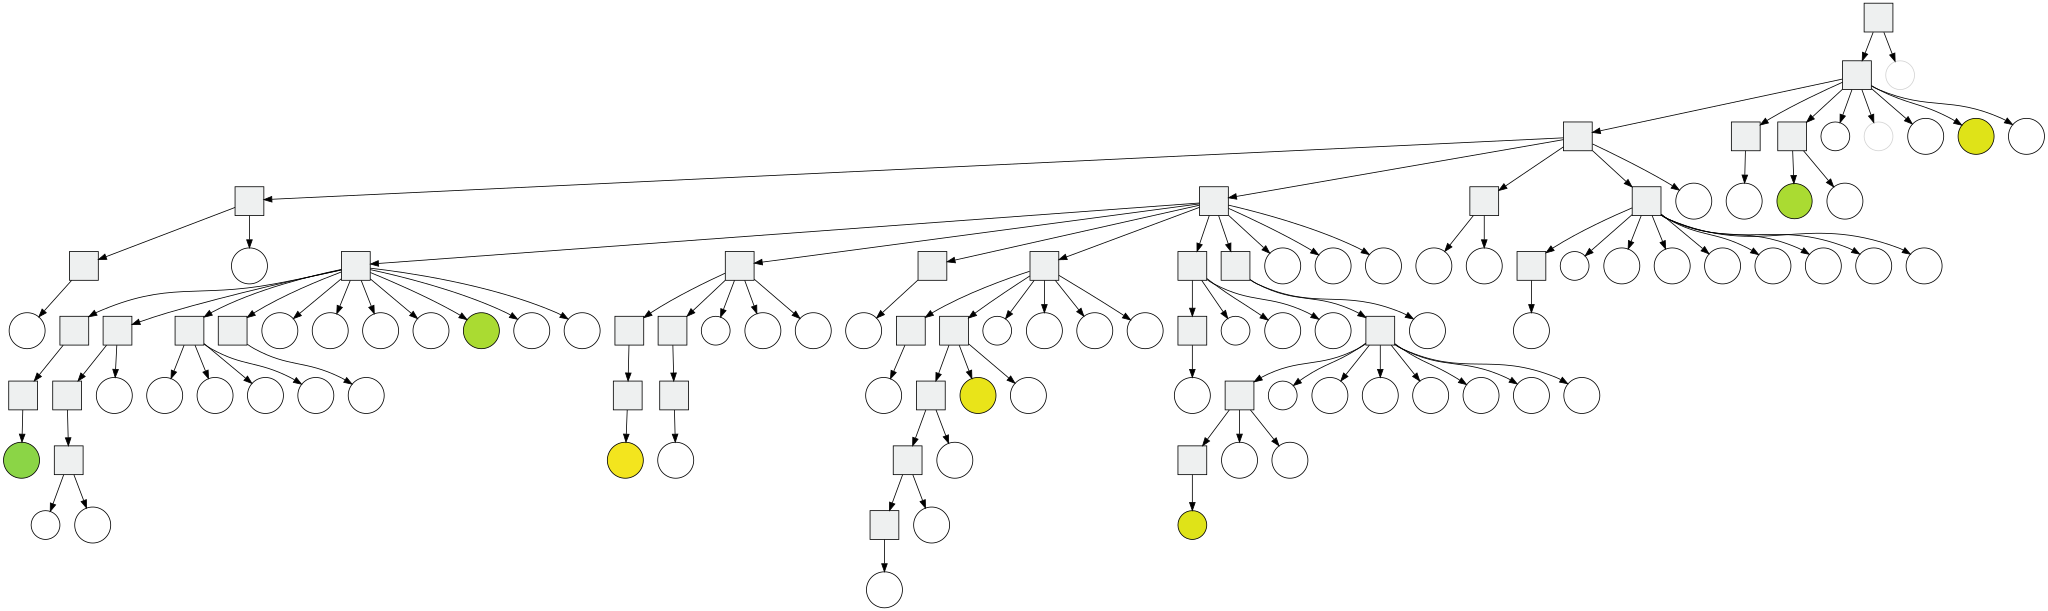

In [160]:
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph

g = to_agraph(tree)
g.layout(prog='dot')
g.draw(f'../../data/YFV2001_figures/0.06_1_map0_IFNG_viridis.svg')
Source(g)